## Introdução

Dataset selecionado: https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs

O dataset possui 30000 registros de músicas do spotify com diversos atributos. O objetivo do trabalho é desenvolver métodos em aprendizado de máquina capazes de prever o gênero de cada música com base em alguns atributos específicos. Os métodos selecionados foram Árvores de Decisão, Naive Bayes e Redes Neurais.

O código abaixo mostra todos os atributos presentes no dataset e filtra os que usaremos. Também é feita uma análise da quantidade de classes e a quantidade de dados para cada classe.

In [ ]:
! gdown 1ddjzjM9cOoi8I1c-hhCFBsiHIXMsBUp7

Downloading...
From: https://drive.google.com/uc?id=1ddjzjM9cOoi8I1c-hhCFBsiHIXMsBUp7
To: /content/spotify_songs.csv
100% 7.97M/7.97M [00:00<00:00, 140MB/s]


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier,  BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
import numpy as np
from functools import reduce

df = pd.read_csv('spotify_songs.csv')

print(df.info())
print("")
print("Classes:\n" + str(df["playlist_genre"].value_counts()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

## Normalização / Tratamento

Primeiro, mapeamos todos os genêros de música para uma classificação numérica.



In [ ]:
x = df[["danceability", "energy", "key", "loudness", "speechiness", "acousticness", "instrumentalness", "valence", "tempo", "mode", "track_popularity", "track_album_release_date"]].copy()
y = df["playlist_genre"].copy()

genres = y.unique()
map_genres = {genre: i for i, genre in enumerate(genres)}
y = y.replace(map_genres)

print(map_genres)
print(y.head())

{'pop': 0, 'rap': 1, 'rock': 2, 'latin': 3, 'r&b': 4, 'edm': 5}
0    0
1    0
2    0
3    0
4    0
Name: playlist_genre, dtype: int64


Codificamos o campo 'key', que representa o tom geral da música, utilizando a técnica one-hot.

In [ ]:
one_hot = pd.get_dummies(x.key, prefix="Key")
x = x.drop('key', axis=1)
x = x.join(one_hot)

  Codificamos o campo "track_album_release_date" através de um inteiro que representa o número de dias desde 0000-00-00

In [ ]:
def toTimestamp(x):
  year = int(x.split('-')[0])

  month = 1
  if (len(x.split('-')) > 1):
      month = int(x.split('-')[1])

  day = 1
  if (len(x.split('-')) > 2):
      day = int(x.split('-')[2])

  return year*365 + (month-1)*12 + (day-1)

x['track_album_release_date'] = x['track_album_release_date'].apply(toTimestamp)

A maioria dos atributos usados já possuem valores normalizados entre 0.0 e 1.0, com exceção de 'loudness', 'tempo', 'track_popularity' e 'track_album_release_date', que serão normalizados abaixo utilizando min-max.

In [ ]:
print("Pré normalização:")
print("Loudness: " + str(x["loudness"].min()) + ":" + str(x["loudness"].max()))
print("Tempo: " + str(x["tempo"].min()) + ":" + str(x["tempo"].max()))
print("Track Popularity: " + str(x["track_popularity"].min()) + ":" + str(x["track_popularity"].max()))
print("Track Album Release Date: " + str(x["track_album_release_date"].min()) + ":" + str(x["track_album_release_date"].max()))

l_min = x["loudness"].min()
l_max = x["loudness"].max()
t_min = x["tempo"].min()
t_max = x["tempo"].max()
p_min = x["track_popularity"].min()
p_max = x["track_popularity"].max()
d_min = x["track_album_release_date"].min()
d_max = x["track_album_release_date"].max()

x["loudness"] = (x["loudness"] - l_min) / (l_max - l_min)
x["tempo"] = (x["tempo"] - t_min) / (t_max - t_min)
x["track_popularity"] = (x["track_popularity"] - p_min) / (p_max - p_min)
x["track_album_release_date"] = (x["track_album_release_date"] - d_min) / (d_max - d_min)

print("\nPós normalização:")
print("Loudness: " + str(x["loudness"].min()) + ":" + str(x["loudness"].max()))
print("Tempo: " + str(x["tempo"].min()) + ":" + str(x["tempo"].max()))
print("Track Popularity: " + str(x["track_popularity"].min()) + ":" + str(x["track_popularity"].max()))
print("Track Album Release Date: " + str(x["track_album_release_date"].min()) + ":" + str(x["track_album_release_date"].max()))

Pré normalização:
Loudness: -46.448:1.275
Tempo: 0.0:239.44
Track Popularity: 0:100
Track Album Release Date: 714305:737328

Pós normalização:
Loudness: 0.0:1.0
Tempo: 0.0:1.0
Track Popularity: 0.0:1.0
Track Album Release Date: 0.0:1.0


O formato completo dos dados após o tratamento pode ser visto abaixo.

In [ ]:
print(x.head())

   danceability  energy  loudness  speechiness  acousticness  \
0         0.748   0.916  0.918090       0.0583        0.1020   
1         0.726   0.815  0.869162       0.0373        0.0724   
2         0.675   0.931  0.901368       0.0742        0.0794   
3         0.718   0.930  0.894118       0.1020        0.0287   
4         0.650   0.833  0.875385       0.0359        0.0803   

   instrumentalness  valence     tempo  mode  track_popularity  ...  Key_2  \
0          0.000000    0.518  0.509673     1              0.66  ...      0   
1          0.004210    0.693  0.417524     1              0.67  ...      0   
2          0.000023    0.613  0.517908     0              0.70  ...      0   
3          0.000009    0.277  0.509338     1              0.60  ...      0   
4          0.000000    0.725  0.517775     1              0.69  ...      0   

   Key_3  Key_4  Key_5  Key_6  Key_7  Key_8  Key_9  Key_10  Key_11  
0      0      0      0      1      0      0      0       0       0  
1      0

## Análise das features

Abaixo fazemos uma breve análise da importância das features do dataset. Para isso criamos uma floresta aleatória simples e treinamos ela com os dados de treino. Utilizando o modelo treinado, plotamos o índice de puridade encontrado no modelo para cada atributo. Quanto maior o valor, mais importante é a feature na determinação da classe.

<ipython-input-10-b53a73266778>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_train_f.columns.values, rotation=90)


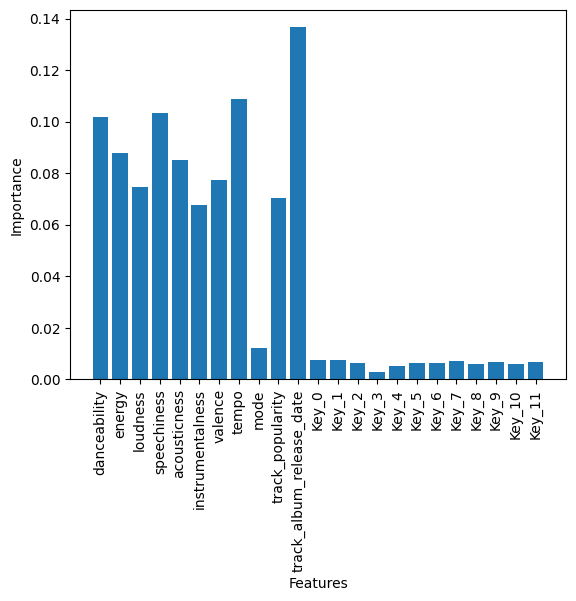

In [ ]:
# Dividindo dados de treino e teste:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(x, y, test_size=0.2)

model = RandomForestClassifier(n_estimators=500)
model.fit(X_train_f, y_train_f)

fig, ax = plt.subplots()

ax.bar(X_train_f.columns.values, model.feature_importances_)
ax.set_xticklabels(X_train_f.columns.values, rotation=90)
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
plt.show()

## Métricas utilizadas
Criamos métodos auxiliares para calcular as métricas e mostrá-las junto com a matriz de confusão.
A matriz de confusão exibida é a soma de todas matrizes de confusão calculadas nos folds.

In [ ]:
# método para calcular as métricas de média e desvio padrão da acurácia
def metricsFromConfusionMatrixes(confusion_matrixes):
    accuracies = []
    sens = np.zeros([len(map_genres), 2])
    prec = np.zeros([len(map_genres), 2])

    for confusion_matrix in confusion_matrixes:
        truePositives = []
        errors = 0

        for i in range(len(confusion_matrix)):
            for j in range(len(confusion_matrix)):
                if j == i:
                    truePositives.append(confusion_matrix[i][j])
                    sens[i][0] += confusion_matrix[i][j]
                    prec[j][0] += confusion_matrix[i][j]
                else:
                    errors += confusion_matrix[i][j]
                    sens[i][1] += confusion_matrix[i][j]
                    prec[j][1] += confusion_matrix[i][j]


        numTruePositives = reduce(lambda x, y: x + y, truePositives)

        accuracies.append(numTruePositives/(errors + numTruePositives))

    return {
        "mean": np.mean(accuracies),
        "std": np.std(accuracies),
        "sens": sens,
        "prec": prec,
    }

# método que mostra a matriz de confusão, junto com as métricas
def showConfusionMatrixAndMetrics(confusion_matrixes, model_name, metrics):
  collabels = ["pop", "rap", "rock", "latin", "r&b", "edm"]

  full_confusion_matrix = reduce(lambda x, y: x + y, confusion_matrixes)

  formatvalues = np.vectorize(lambda x: f'{int(x)}')
  full_confusion_matrix_text = formatvalues(full_confusion_matrix)

  fig, ax = plt.subplots()
  ax.axis('off')


  table = ax.table(
      cellText=full_confusion_matrix_text,
      colLabels=collabels,
      rowLabels=collabels,
      loc='center',
      cellLoc='center',
      cellColours=[[(0.8, 1, 0.8) if x == i else (1, 0.8, 0.8) for x in range(
          len(collabels))] for i in range(len(collabels))],
  )
  table.scale(1,2.3)

  metrics = metricsFromConfusionMatrixes(confusion_matrixes)

  mean = metrics["mean"]
  std = metrics["std"]
  sens = metrics["sens"]
  prec = metrics["prec"]

  fig.tight_layout()
  plt.title(f'Matriz de Confusão - {model_name}')
  plt.subplots_adjust(bottom=0.2)
  plt.text(-0.12, 0.40, "Correto", fontsize=12, rotation=90)
  plt.text(0.40, 0.9, "Predito", fontsize=12)
  plt.text(0.0, 0.0, f"Acurácia Média: {mean*100:.2f}%", fontsize=12)
  plt.text(0.0, -0.09, f"Desvio Padrão: {std*100:.2f}%", fontsize=12)
  for i in range(len(sens)):
    plt.text(0.0, -0.09 * (i + 2), f"{collabels[i]} -> Sensibilidade: {100 * sens[i][0] / (sens[i][0] + sens[i][1]):.2f}% / Precisão: {100 * prec[i][0] / (prec[i][0] + prec[i][1]):.2f}%", fontsize=12)
  plt.show()

Abaixo definimos os valores de k utilizados para verificação

In [ ]:
k_fold_values = [5, 10, 20]

## Árvores de Decisão

In [ ]:
confusion_matrixes_dt = []

for folds in k_fold_values:

  kf = KFold(n_splits=folds, random_state=0, shuffle=True)

  true_positives = []

  # Para cada fold, separa em treino e teste
  for fold, (train, test) in enumerate(kf.split(x)):
    confusion_matrix_dt = np.zeros((6, 6))

    X_train, X_test, y_train, y_test = x.iloc[train], x.iloc[test], y.iloc[train], y.iloc[test]
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    true_positives.append(100 - (y_test != y_pred).sum() * 100 / X_test.shape[0])

    # constrói a matriz de confusão
    for i in range(y_pred.shape[0]):
      predicted = y_pred[i]
      actual = y_test.iloc[i]

      confusion_matrix_dt[actual][predicted] += 1

    # adiciona à lista de matrizes de confusão, para calcular a média e desvio da acurácia
    confusion_matrixes_dt.append(confusion_matrix_dt)

  print(f'Acurácia média para Arvore de decisão com {folds} folds: {(np.mean(true_positives)):.2f}%')

Acurácia média para Arvore de decisão com 5 folds: 46.76%
Acurácia média para Arvore de decisão com 10 folds: 46.86%
Acurácia média para Arvore de decisão com 20 folds: 47.20%


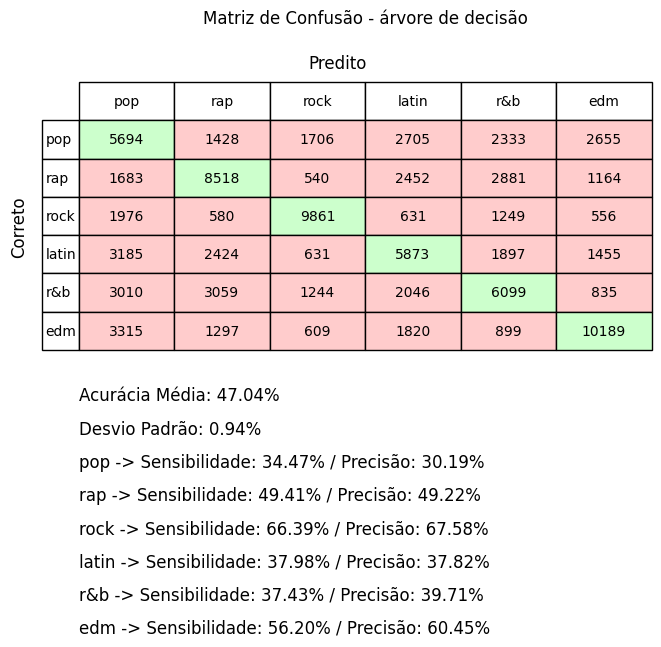

In [ ]:
metrics = metricsFromConfusionMatrixes(confusion_matrixes_dt)
showConfusionMatrixAndMetrics(confusion_matrixes_dt, 'árvore de decisão', metrics)

In [ ]:
confusion_matrixes_dtb = []

for folds in k_fold_values:

  kf = KFold(n_splits=folds, random_state=0, shuffle=True)

  true_positives = []

  # Para cada fold, separa em treino e teste
  for fold, (train, test) in enumerate(kf.split(x)):
    confusion_matrix_dtb = np.zeros((6, 6))

    base_classifier = DecisionTreeClassifier(random_state=42)
    X_train, X_test, y_train, y_test = x.iloc[train], x.iloc[test], y.iloc[train], y.iloc[test]
    model = BaggingClassifier(base_classifier, n_estimators=200, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    true_positives.append(100 - (y_test != y_pred).sum() * 100 / X_test.shape[0])

    # constrói a matriz de confusão
    for i in range(y_pred.shape[0]):
      predicted = y_pred[i]
      actual = y_test.iloc[i]

      confusion_matrix_dtb[actual][predicted] += 1

    # adiciona à lista de matrizes de confusão, para calcular a média e desvio da acurácia
    confusion_matrixes_dtb.append(confusion_matrix_dtb)

  print(f'Acurácia média para Ensembles Bagging com {folds} folds: {(np.mean(true_positives)):.2f}%')

Acurácia média para Ensembles Bagging com 5 folds: 57.50%
Acurácia média para Ensembles Bagging com 10 folds: 58.03%
Acurácia média para Ensembles Bagging com 20 folds: 58.03%


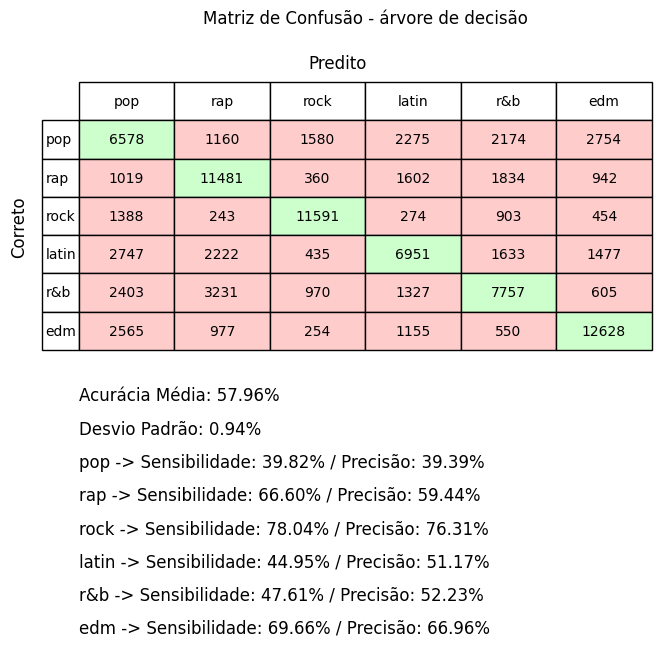

In [ ]:
metrics = metricsFromConfusionMatrixes(confusion_matrixes_dt)
showConfusionMatrixAndMetrics(confusion_matrixes_dt, 'árvore de decisão', metrics)

## Naive Bayes

### Gaussian Naive Bayes

Para lidar com features numéricas, usamos a versão gaussiana do Naive Bayes: assume que as features seguem uma distribuição normal para calcular a probabilidade de cada classe.

In [ ]:
confusion_matrixes_nb = []

for folds in k_fold_values:

  true_positives = []

  kf = KFold(n_splits=folds, random_state=0, shuffle=True)

  # Para cada fold, separa em treino e teste
  for fold, (train, test) in enumerate(kf.split(x)):
    confusion_matrix_nb = np.zeros((6, 6))

    X_train, X_test, y_train, y_test = x.iloc[train], x.iloc[test], y.iloc[train], y.iloc[test]
    gnb = GaussianNB()
    y_pred = gnb.fit(X_train, y_train).predict(X_test)

    true_positives.append(100 - (y_test != y_pred).sum() * 100 / X_test.shape[0])

    # constrói a matriz de confusão
    for i in range(y_pred.shape[0]):
      predicted = y_pred[i]
      actual = y_test.iloc[i]

      confusion_matrix_nb[actual][predicted] += 1

    # adiciona à lista de matrizes de confusão, para calcular a média e desvio da acurácia
    confusion_matrixes_nb.append(confusion_matrix_nb)

  print(f'Acurácia média para Gaussian Naive Bayes com {folds} folds: {np.mean(true_positives):.2f}%')

Acurácia média para Gaussian Naive Bayes com 5 folds: 45.47%
Acurácia média para Gaussian Naive Bayes com 10 folds: 45.43%
Acurácia média para Gaussian Naive Bayes com 20 folds: 45.40%


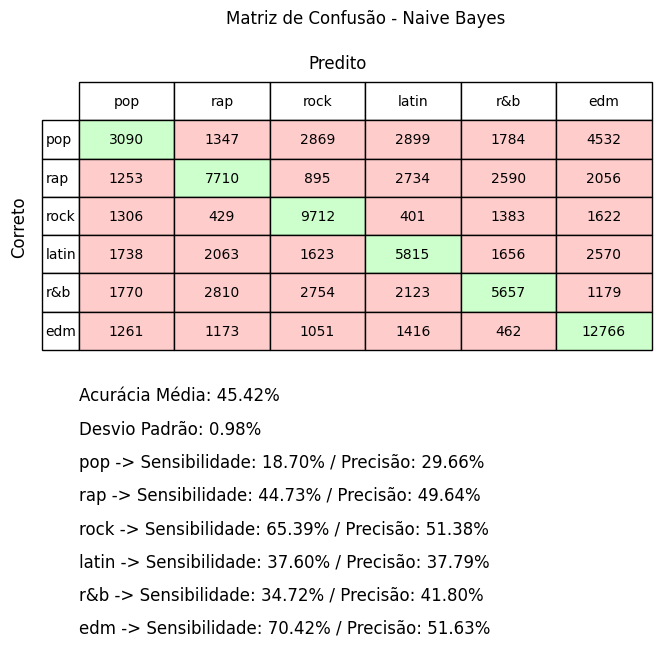

In [ ]:
metrics = metricsFromConfusionMatrixes(confusion_matrixes_nb)
showConfusionMatrixAndMetrics(confusion_matrixes_nb, 'Naive Bayes', metrics)

## Redes Neurais
### Tensorflow/Keras

Por dar mais liberdade na criação da rede, optamos por tensorflow na modelagem da rede neural.

A rede neural utilizada foi modelada da seguinte forma:
- Duas camadas de convolução 1D com 32 e 64 matrizes respectivemente para detecção de padrões nos dados. Ambas as camadas são seguidas de max-pooling para diminuição da entrada.
- Duas camadas de 128 e 256 neurônios respectivamente.
- Ativação ReLU em todas as camadas.
- Dropout utilizado entre as camadas de neurônios para atenuar overfitting.
- Saída utilizando softmax para lista de probabilidades de classe.
Com esta modelagem obtemos os melhores resultados para o dataset com rede neural.


In [ ]:
num_classes = len(map_genres)

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(32, 2, activation='relu', input_shape=(23, 1)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(64, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

opt = tf.keras.optimizers.Adam(learning_rate=0.001,)

model.compile(optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

Abaixo rodamos a rede neural para k = 5, 10 e 20 e calculamos as acurácias médias e a matriz de confusão.

In [ ]:
confusion_matrixes_nn = []

for folds in k_fold_values:

  kf = KFold(n_splits=folds, random_state=0, shuffle=True)

  true_positives = []

  # Para cada fold, separa em treino e teste
  for fold, (train, test) in enumerate(kf.split(x)):
    confusion_matrix_nn = np.zeros((6, 6))

    X_train, X_test, y_train, y_test = x.iloc[train], x.iloc[test], y.iloc[train], y.iloc[test]

    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    y_pred = np.argmax(model.predict(X_test, verbose=0), 1)

    true_positives.append(100 - (y_test != y_pred).sum() * 100 / X_test.shape[0])

    # constrói a matriz de confusão
    for i in range(y_pred.shape[0]):
      predicted = y_pred[i]
      actual = y_test.iloc[i]

      confusion_matrix_nn[actual][predicted] += 1

    # adiciona à lista de matrizes de confusão, para calcular a média e desvio da acurácia
    confusion_matrixes_nn.append(confusion_matrix_nn)

  print(f'Acurácia média para Rede Neural com {folds} folds: {(np.mean(true_positives)):.2f}%')

Acurácia média para Rede Neural com 5 folds: 59.63%
Acurácia média para Rede Neural com 10 folds: 65.31%
Acurácia média para Rede Neural com 20 folds: 69.45%


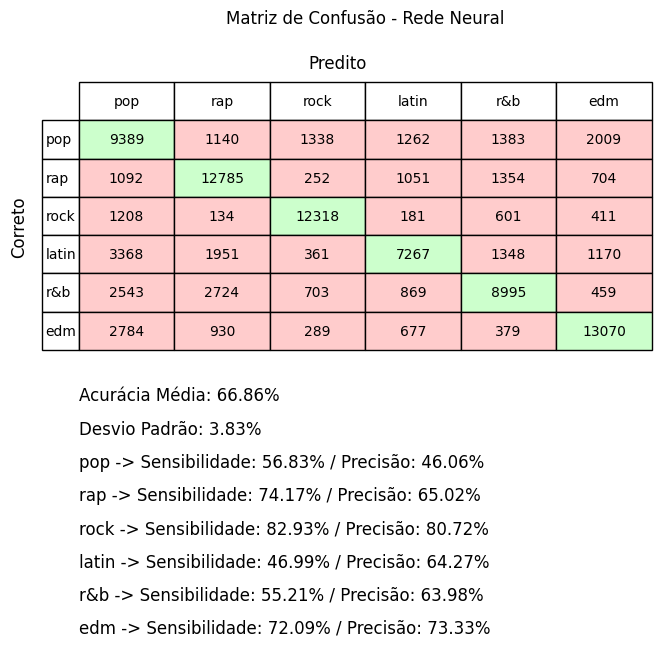

In [ ]:
metrics = metricsFromConfusionMatrixes(confusion_matrixes_nn)
showConfusionMatrixAndMetrics(confusion_matrixes_nn, 'Rede Neural', metrics)